In [1]:

import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [2]:


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [3]:
ns = 10000
sim = 'r1'
n = 4
dim = 2
nt = 1000
dt = 5e-3

### Generate the dataset and see the shape

In [4]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [5]:
simulation.data.shape

(10000, 500, 4, 6)

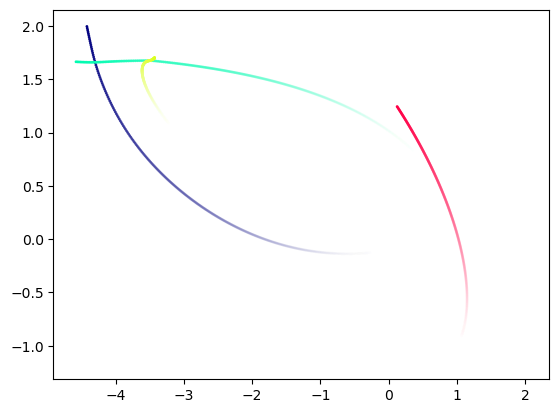

In [6]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [7]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [8]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [9]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]

test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in range(len(Y_test))
]


batch = int(64 * (4 / n) ** 2)

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/DIS-final-project/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [10]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]

In [11]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [12]:

model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [13]:
import wandb
wandb.init(project="DIS-final-project", name="Train-r1-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 15.243734
Epoch 2/30, Loss: 9.689633
Epoch 3/30, Loss: 6.824017
Epoch 4/30, Loss: 4.699589
Epoch 5/30, Loss: 3.481295
Epoch 6/30, Loss: 3.035772
Epoch 7/30, Loss: 3.129012
Epoch 8/30, Loss: 3.074371
Epoch 9/30, Loss: 2.989977
Epoch 10/30, Loss: 2.895230
Epoch 11/30, Loss: 2.740063
Epoch 12/30, Loss: 2.681609
Epoch 13/30, Loss: 2.561607
Epoch 14/30, Loss: 2.388078
Epoch 15/30, Loss: 2.298038
Epoch 16/30, Loss: 2.192691
Epoch 17/30, Loss: 2.115827
Epoch 18/30, Loss: 1.928507
Epoch 19/30, Loss: 1.796414
Epoch 20/30, Loss: 1.652742
Epoch 21/30, Loss: 1.504725
Epoch 22/30, Loss: 1.319810
Epoch 23/30, Loss: 1.133352
Epoch 24/30, Loss: 1.009952
Epoch 25/30, Loss: 0.818128
Epoch 26/30, Loss: 0.672763
Epoch 27/30, Loss: 0.539533
Epoch 28/30, Loss: 0.442603
Epoch 29/30, Loss: 0.388573
Epoch 30/30, Loss: 0.365356


In [14]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r1_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [15]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r1_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_23048/3986128128.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [16]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.059490


Selected channels: ['msg1', 'msg99']


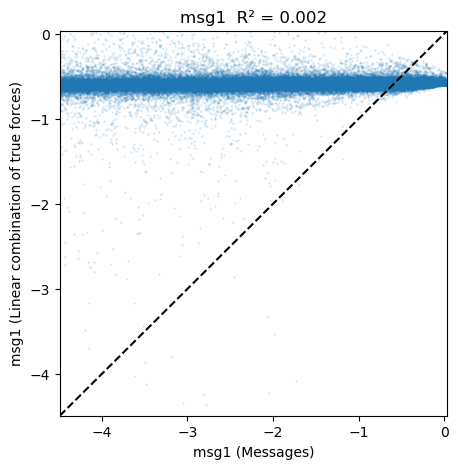

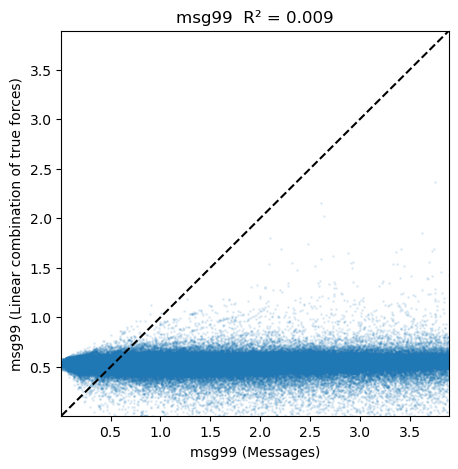

In [17]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dx'] / (latent_df_standard['r'] ** 2 + 1e-5))
latent_df_standard['fy_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dy'] / (latent_df_standard['r'] ** 2 + 1e-5))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

# 
for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]          
    y_pred_ch = Predicted_messages[:, idx] 

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [18]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=80,
  binary_operators=["+", "-", "*", "/","^"]
)
df_sub_standard = latent_df_standard[['dx','dy','r','m1','m2', top_channels[0]]].sample(5000)
X = df_sub_standard[['dx','dy','r','m1','m2']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 9.370e+04
Progress: 484 / 2480 total iterations (19.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.371e+00  1.594e+01  y = -0.58037
3           7.851e-01  2.787e-01  y = x₄ * -0.36339
5           4.047e-01  3.314e-01  y = x₄ * (-0.21619 / x₂)
7           1.977e-01  3.582e-01  y = (x₄ * -0.4044) / (x₂ + 0.15054)
9           1.871e-01  2.738e-02  y = (-0.37402 / (x₂ + 0.14679)) * (x₄ + 0.33335)
11          1.713e-01  4.413e-02  y = -1.5508 / ((((x₂ / 0.2728) - -0.34036) / x₄) - -0.0316...
                                      99)
13          1.098e-01  2.224e-01  y = -1.5508 / ((((x₂ / 0.2728) - (-0.32013 - x₁)) / x₄) - ...
                                      -0.031699)
29          1.078e-01  1.133e-03  y = ((0.6735 / ((1.2128 / (x₂ ^ -1.

### Bottleneck model

In [19]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [20]:
import wandb
wandb.init(project="DIS-final-project", name="Train-r1-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.36536


Epoch 1/30, Loss: 17.801486
Epoch 2/30, Loss: 11.091107
Epoch 3/30, Loss: 8.620945
Epoch 4/30, Loss: 7.244007
Epoch 5/30, Loss: 5.302488
Epoch 6/30, Loss: 3.938120
Epoch 7/30, Loss: 3.301409
Epoch 8/30, Loss: 2.957784
Epoch 9/30, Loss: 2.801027
Epoch 10/30, Loss: 2.699319
Epoch 11/30, Loss: 2.591446
Epoch 12/30, Loss: 2.477524
Epoch 13/30, Loss: 2.401053
Epoch 14/30, Loss: 2.268503
Epoch 15/30, Loss: 2.165696
Epoch 16/30, Loss: 2.045317
Epoch 17/30, Loss: 1.897644
Epoch 18/30, Loss: 1.776746
Epoch 19/30, Loss: 1.631848
Epoch 20/30, Loss: 1.516088
Epoch 21/30, Loss: 1.365786
Epoch 22/30, Loss: 1.234854
Epoch 23/30, Loss: 1.092237
Epoch 24/30, Loss: 0.949764
Epoch 25/30, Loss: 0.810699
Epoch 26/30, Loss: 0.689093
Epoch 27/30, Loss: 0.576828
Epoch 28/30, Loss: 0.499252
Epoch 29/30, Loss: 0.448517
Epoch 30/30, Loss: 0.426748


In [21]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [22]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.078599


Selected channels: ['msg0', 'msg1']


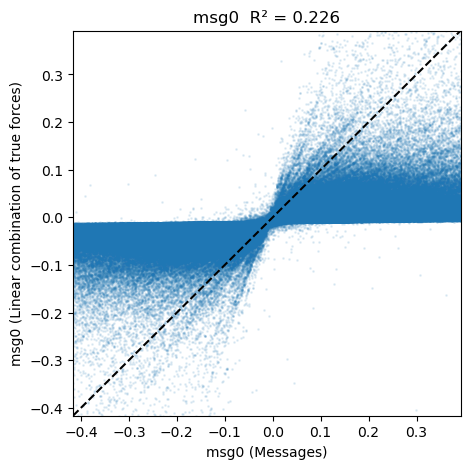

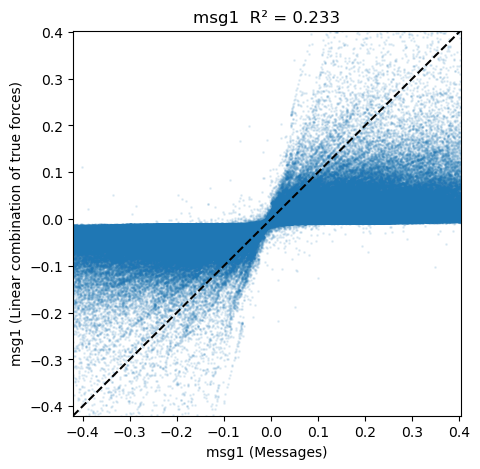

In [27]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score


# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 2 + 1e-6))
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 2 + 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])
    mask = (y_true_ch >= p_lower) & (y_true_ch <= p_upper) & (y_pred_ch >= p_lower) & (y_pred_ch <= p_upper)

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")
    

    single_r2 = r2_score(y_true_ch[mask], y_pred_ch[mask])
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()

In [28]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/","^"]
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', 'm1','m2', top_channels[0]]].sample(5000)
X = df_sub_bottleneck[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 1.320e+05
Progress: 766 / 2170 total iterations (35.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.166e-02  1.594e+01  y = -0.011978
3           5.856e-02  2.579e-02  y = -0.023155 / x₂
5           5.229e-02  5.661e-02  y = x₁ / (6.6586 ^ x₂)
7           3.312e-02  2.283e-01  y = x₄ * (x₁ * (0.083992 ^ x₂))
9           3.902e-03  1.069e+00  y = (((x₄ * x₁) / x₂) * 0.051464) / x₂
11          4.164e-04  1.119e+00  y = (x₄ * ((x₁ / x₂) / (x₂ + 0.01714))) * 0.070022
13          3.587e-04  7.457e-02  y = ((((x₁ * x₄) / x₂) - 0.019237) / (x₂ + 0.01557)) * 0.0...
                                      69209
17          2.905e-04  5.271e-02  y = (((((x₄ * x₁) * (-0.61305 / x₂)) / 5.6984) * -0.64403)...
                                       / (x₂ 

### L1 regularization model

In [29]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [30]:
wandb.init(project="DIS-final-project", name="Train-r1-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.42675


Epoch 1/30, Loss: 25.383992
Epoch 2/30, Loss: 21.673664
Epoch 3/30, Loss: 14.302820
Epoch 4/30, Loss: 8.806258
Epoch 5/30, Loss: 6.993379
Epoch 6/30, Loss: 6.425395
Epoch 7/30, Loss: 6.381301
Epoch 8/30, Loss: 6.350662
Epoch 9/30, Loss: 6.351613
Epoch 10/30, Loss: 6.162233
Epoch 11/30, Loss: 6.068041
Epoch 12/30, Loss: 5.848660
Epoch 13/30, Loss: 5.701999
Epoch 14/30, Loss: 5.561831
Epoch 15/30, Loss: 5.404685
Epoch 16/30, Loss: 5.277324
Epoch 17/30, Loss: 5.126373
Epoch 18/30, Loss: 4.921591
Epoch 19/30, Loss: 4.755231
Epoch 20/30, Loss: 4.555157
Epoch 21/30, Loss: 4.349182
Epoch 22/30, Loss: 4.163215
Epoch 23/30, Loss: 3.970242
Epoch 24/30, Loss: 3.791452
Epoch 25/30, Loss: 3.379236
Epoch 26/30, Loss: 3.008430
Epoch 27/30, Loss: 2.768575
Epoch 28/30, Loss: 2.523266
Epoch 29/30, Loss: 2.412189
Epoch 30/30, Loss: 2.369256


In [31]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [32]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.340663


Selected channels: ['msg65', 'msg7']


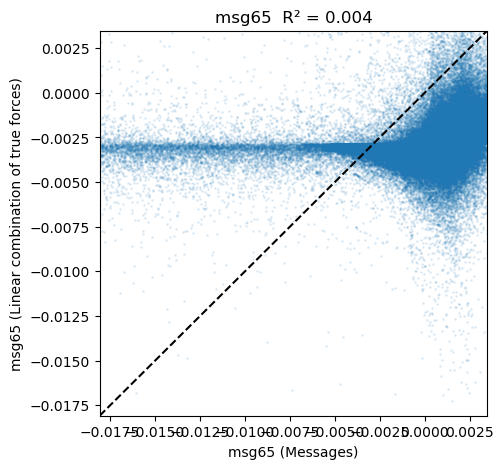

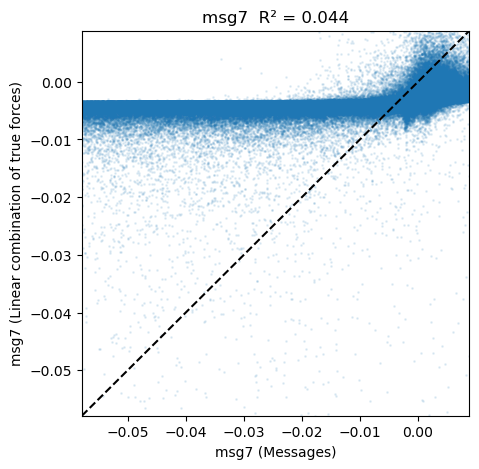

In [33]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dx'] / (latent_df_l1['r'] ** 2 + 1e-5))
latent_df_l1['fy_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dy'] / (latent_df_l1['r'] ** 2 + 1e-5))


# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [41]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/", "^"]  
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', 'm1','m2',top_channels[0]]].sample(5000)
X = df_sub_l1[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_l1[top_channels[0]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.690e+04
Progress: 571 / 2170 total iterations (26.313%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.378e-02  1.594e+01  y = 0.019927
3           8.614e-03  2.348e-01  y = 0.00031752 ^ x₂
5           6.856e-03  1.141e-01  y = (x₄ / x₂) * 0.010154
7           6.648e-03  1.542e-02  y = ((x₄ + 0.76858) / x₂) * 0.0088741
9           5.603e-03  8.551e-02  y = ((x₄ + (x₀ / x₂)) * 0.010442) / x₂
11          4.944e-03  6.256e-02  y = (((x₀ * (2.616 / x₂)) + x₄) * 0.0093935) / x₂
13          3.649e-03  1.519e-01  y = ((0.0087432 / x₂) * ((x₀ + (x₁ + x₂)) / x₂)) * x₄
15          2.859e-03  1.220e-01  y = ((((x₂ + x₁) + x₀) * (0.0069489 / x₂)) / x₂) * (x₄ + 1...
                                      .4122)
19          2.768e-03  8.025e-03  y = ((0.007

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 8.380e+04
Progress: 1854 / 2170 total iterations (85.438%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.378e-02  1.594e+01  y = 0.019927
3           8.614e-03  2.348e-01  y = 0.0003147 ^ x₂
5           6.856e-03  1.141e-01  y = (x₄ * 0.010155) / x₂
7           5.833e-03  8.079e-02  y = (0.010986 ^ (x₂ + 0.35729)) * x₄
9           4.285e-03  1.542e-01  y = (x₄ * 0.009865) ^ ((x₂ + x₂) - x₀)
11          3.548e-03  9.439e-02  y = (x₄ ^ (x₀ - -0.55924)) * (0.0078048 ^ (x₂ + 0.15529))
13          3.458e-03  1.282e-02  y = ((x₄ ^ (x₀ - -0.54163)) * (0.011266 ^ (x₂ + 0.16143)))...
                                       ^ 1.1798
15          1.858e-03  3.106e-01  y = ((x₄ ^ (x₂ - -0.25159)) * (0.013222 ^ ((x₂ + x₂) - x₀)...
                           

### KL divergence model

In [34]:
from models import VariationNbody

In [35]:
model_kl = VariationNbody(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [36]:
import wandb
wandb.init(project="DIS-final-project-kl", name="Train-r1", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,30
train_loss,2.36926


Epoch 1/30, Loss: 3.188068
Epoch 2/30, Loss: 3.113795
Epoch 3/30, Loss: 3.084550
Epoch 4/30, Loss: 3.029877
Epoch 5/30, Loss: 2.989937
Epoch 6/30, Loss: 2.974928
Epoch 7/30, Loss: 2.969952
Epoch 8/30, Loss: 2.967747
Epoch 9/30, Loss: 2.960933
Epoch 10/30, Loss: 2.950513
Epoch 11/30, Loss: 2.885934
Epoch 12/30, Loss: 2.802982
Epoch 13/30, Loss: 2.777609
Epoch 14/30, Loss: 2.760576
Epoch 15/30, Loss: 2.746440
Epoch 16/30, Loss: 2.730032
Epoch 17/30, Loss: 2.719076
Epoch 18/30, Loss: 2.705257
Epoch 19/30, Loss: 2.690011
Epoch 20/30, Loss: 2.676763
Epoch 21/30, Loss: 2.659436
Epoch 22/30, Loss: 2.646549
Epoch 23/30, Loss: 2.630557
Epoch 24/30, Loss: 2.617353
Epoch 25/30, Loss: 2.605398
Epoch 26/30, Loss: 2.595655
Epoch 27/30, Loss: 2.586703
Epoch 28/30, Loss: 2.581030
Epoch 29/30, Loss: 2.576879
Epoch 30/30, Loss: 2.574791


In [37]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [38]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.181741


Top μ channels: ['mu21', 'mu74']
Multi-output μ‐linear fit R² = 0.1266


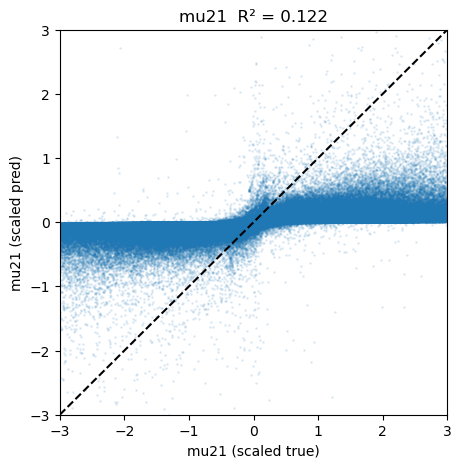

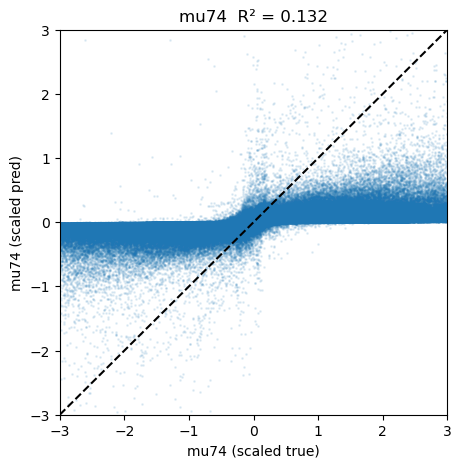

In [39]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# 1) 选出方差最大的 dim 个 mu 通道
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# 2) 计算真实力，并拼成 X
df['fx_true'] = (df['m1'] * df['m2']) * (df['dx'] / (df['r'] ** 2 + 1e-5))
df['fy_true'] = (df['m1'] * df['m2']) * (df['dy'] / (df['r'] ** 2 + 1e-5))


X_raw = df[['fx_true','fy_true']].values       # (N,2)
Y_mu   = df[top_mu].values                     # (N,dim)

# 3) 标准化
scaler_X  = StandardScaler().fit(X_raw)
scaler_Ymu = StandardScaler().fit(Y_mu)
Xs  = scaler_X.transform(X_raw)
Ysm = scaler_Ymu.transform(Y_mu)

# 4) 拟合 & 得到整体 R²
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")

# 5) 可视化：每个 μ 通道的真值 vs 预测
for i, ch in enumerate(top_mu):
    Y_true = Ysm[:, i]
    Y_pred = lr_mu.predict(Xs)[:, i]

    plt.figure(figsize=(5,5))
    plt.scatter(Y_true, Y_pred, s=1, alpha=0.1)
    plt.plot([-3,3],[-3,3],'k--')
    plt.xlim(-3,3); plt.ylim(-3,3)
    plt.xlabel(f"{ch} (scaled true)")
    plt.ylabel(f"{ch} (scaled pred)")
    r2_chan = r2_score(Y_true, Y_pred)
    plt.title(f"{ch}  R² = {r2_chan:.3f}")
    plt.show()

In [48]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/", "^"]
)
df_sub_kl = df[['dx', 'dy', 'r', 'm1','m2',top_mu[0]]].sample(5000)
X = df_sub_kl[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.030e+04
Progress: 489 / 2170 total iterations (22.535%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.630e-01  1.594e+01  y = 0.0094781
3           2.505e-01  2.450e-02  y = -0.033202 / x₂
5           2.476e-01  5.692e-03  y = (-0.039245 / x₂) + 0.057013
7           1.822e-01  1.534e-01  y = (x₀ * (0.0002287 ^ x₂)) / -0.039724
9           1.306e-01  1.664e-01  y = (x₀ + 0.0072351) * ((-0.15523 / x₂) / x₂)
11          1.131e-01  7.213e-02  y = (0.0033563 ^ (x₂ - 0.13482)) / ((x₂ / -2.2366) / x₀)
13          1.098e-01  1.452e-02  y = (0.00079372 ^ (x₂ - 0.13254)) / ((x₂ / -1.8452) / (x₀ ...
                                      / 0.77632))
15          9.818e-02  5.611e-02  y = (x₁ - (((0.0034936 ^ x₂) * (x₀ + 0.025444)) * (x₄ / x₂...
         

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.630e-01  1.594e+01  y = 0.0094781
3           2.505e-01  2.450e-02  y = -0.033202 / x₂
5           2.455e-01  1.000e-02  y = (3.3218e-06 ^ x₂) * -2.3875
7           1.131e-01  3.877e-01  y = x₀ * ((9.2702e-07 ^ x₂) / -0.0071883)
9           1.094e-01  1.635e-02  y = ((x₀ * -6.0174) / x₂) / (1684.4 ^ x₂)
11          7.856e-02  1.657e-01  y = (((x₀ - -0.010259) * -6.8861) / x₂) / (4490.7 ^ x₂)
13          4.455e-02  2.836e-01  y = (((x₀ - -0.012933) * (-3.6224 - x₄)) / x₂) / (873.67 ^...
                                       x₂)
15          3.806e-02  7.869e-02  y = ((x₀ - -0.012283) / ((x₄ ^ -0.48699) * (732.72 ^ x₂)))...
                                       * (-4.4231 / x₂)
17          3.371e-02  6.071e-02  y = ((x₀ + 0.012012) * (-7.5983 / x₂)) / (((10671 ^ x₂) * ...
                                      (x₄ ^ -0.77419)) - -0.6